# Supervised and Unsipervised Quantum Machine Learning models for the phase detection of the ANNNI spin model

*Author: Saverio Monaco --- Posted: ? ? 2025. Last updated: ? ? 2025.*

Quantum Machine Learning (QML) models are well-suited tools for analyzing quantum many-body systems thanks to the natural one-to-one mapping between spins and qubits.

By using the ground states of spin systems as inputs to our model, both supervised and unsupervised techniques can be developed to study phase transitions of such systems.

In this demo, we implement both learning approaches to explore the phase diagram of the Axial Next-Nearest-Neighbor Ising (ANNNI) model.

The supervised model, a Quantum Convolutional Neural Network (QCNN), is trained exclusively on analytically known points of the phase diagram (a small subset) demonstrating its generalization capabilities.

The unsupervised model, Quantum Anomaly Detection (QAD), requires minimal training and offers a powerful tool for identifying potential phases in systems where little prior knowledge is available.

In [1]:
import pennylane as qml
import numpy as np
from jax import jit, vmap, value_and_grad, random, config
from jax import numpy as jnp
import optax

import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

config.update("jax_enable_x64", False)

seed = 12

# The ANNNI model

The ANNNI model describes a spin system with competing interactions. Its Hamiltonian is given by:
$$ H =   J \sum_{i=1}^{N} \sigma_x^i\sigma_x^{i+1} - \kappa \sigma_x^{i}\sigma_x^{i+2} + h \sigma_z^i$$
where:
* $\sigma_a^i$ are the Pauli matrices acting on the $i$-th spin ($a \in \{x, y, z\}$)
* $J$ is the nearest-neighbor coupling constant, which we set to $1$ without any loss of generality
* $\kappa$ constrols the intensity next-nearest-neighbor interaction
* $h$ represents the strength of the transverse magnetic field

Without loss of generality, we set $J = 1$ and consider open boundary conditions for positive $\kappa$ and $h$.

In [2]:
# Construct the ANNNI Hamiltonian (with J=1)
def get_H(num_spins, k, h):
    # Interaction between spins (neighbouring):
    H = -1 * (qml.PauliX(0) @ qml.PauliX(1))
    for i in range(1, num_spins - 1):
        H = H  - (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Interaction of spins with magnetic field
    for i in range(0, num_spins):
        H = H - h * qml.PauliZ(i)

    # Interaction between spins (next-neighbouring):
    for i in range(0, num_spins - 2):
        H = H + k * (qml.PauliX(i) @ qml.PauliX(i + 2))

    return H

Due to the competition between the three types of interactions, the ANNNI model exhibits a rich and complex phase diagram:

- **Ising transition line** occurs at:  
  $$ h_I(\kappa) \approx \frac{1 - \kappa}{\kappa} \left(1 - \sqrt{\frac{1 - 3 \kappa + 4 \kappa^2 }{1 - \kappa}} \right)$$  
  which separates the _ferromagnetic_ phase from the _paramagnetic_ phase.

- **Kosterlitz-Thouless (KT) transition line** occurs at:  
  $$ h_C(\kappa) \approx 1.05 \sqrt{(\kappa - 0.5) (\kappa - 0.1)} $$  
  which separates the _paramagnetic_ phase from the _antiphase_.


Additionally, another phase transition has been numerically addressed but not yet confirmed:

- **Berezinskii-Kosterlitz-Thouless (BKT) transition line** occurs at:  
  $$ h_{BKT} \approx 1.05 (\kappa - 0.5) $$  
  which entirely lies within the _antiphase_.

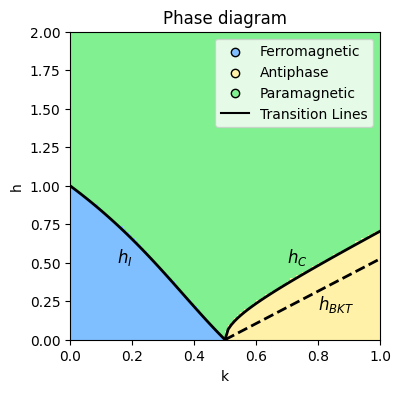

In [3]:
# Kosterlitz-Thouless transition line
def kt_transition(k):
    return 1.05 * np.sqrt((k - 0.5) * (k - 0.1))

# Ising transition line
def ising_transition(k):
    return np.where(k == 0, 1, (1 - k) * (1 - np.sqrt((1 - 3 * k + 4 * k**2) / (1 - k))) / np.maximum(k, 1e-9))

# Floating Phase transition line
def bkt_transition(k):
    return 1.05 * (k - 0.5)
    
# Get the phase from the DMRG transition lines
def get_phase(k, h):
    if k < .5 and h < ising_transition(k):
        return 0
    elif k > .5 and h < kt_transition(k):
        return 1
    return 2

# Generate the phase diagram data from DMRG transition lines
ks100, hs100 = np.linspace(0, 1, 100), np.linspace(0, 2, 100)
K100, H100 = np.meshgrid(ks100, hs100)
img_dmrg = np.vectorize(get_phase)(K100, H100)

colors = ['#80bfff', '#fff2a8',  '#80f090', '#da8080',]
phase_labels = ["Ferromagnetic", "Antiphase", "Paramagnetic", "Trash Class",]
cmap = ListedColormap(colors)

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

# Plot the phase diagram
plt.figure(figsize=(4, 4))
plt.imshow(img_dmrg, cmap=cmap, aspect="auto", origin="lower", extent=[0, 1, 0, 2], norm=norm)

# Plot the transition lines.
k_vals1 = np.linspace(0.0, 0.5, 50)
k_vals2 = np.linspace(0.5, 1.0, 50)
plt.plot(k_vals1, ising_transition(k_vals1), 'k', lw=2)
plt.plot(k_vals2, kt_transition(k_vals2), 'k', lw=2)
plt.plot(k_vals2, bkt_transition(k_vals2), 'k', ls = '--', lw=2)

# Create legend entries
for color, phase in zip(colors, phase_labels[:-1]):
    plt.scatter([], [], color=color, label=phase, edgecolors='black')
plt.plot([], [], 'k', label='Transition Lines')
plt.text(0.15, 0.5, s=r'$h_I$', fontsize=12)
plt.text(0.70, 0.5, s=r'$h_C$', fontsize=12)
plt.text(0.8, 0.2, s=r'$h_{BKT}$', fontsize=12)

plt.legend(), plt.xlabel("k"), plt.ylabel("h"), plt.title("Phase diagram"), plt.show();

In [4]:
num_qubits = 8 # Number of spins in the Hamiltonian (= number of qubits)
side = 20      # Discretization of the Phase Diagram

# State Preparation  

The ground states of the system serve as inputs for both QML models. Several methods can be used to obtain these states, such as:  

* **Variational Quantum Eigensolver (VQE)**  
VQE is a technique introduced in [^3] which leverages the Rayleigh-Ritz variational principle to approximate the lowest-energy states of a given Hamiltonian.  

* **Matrix Product States (MPS)**  
MPS can be efficiently computed on classical hardware at a low cost and provide accurate approximations for local quantum systems. Several techniques are being developed to optimally embed MPS into quantum circuits.  


For simplicity, in this demo, we compute the ground state directly by finding the eigenvector corresponding to the lowest eigenvalue of the Hamiltonian. The resulting states are then loaded into the quantum circuits using PennyLane’s `qml.StatePrep`.  

It is important to note that this approach is only feasible within the classically simulable regime, as it becomes quickly intractable for larger system sizes.

In [5]:
def diagonalize_H(H_matrix):
    """Returns the lowest eigenvector of the Hamiltonian matrix."""
    _, psi = jnp.linalg.eigh(H_matrix)  # Compute eigenvalues and eigenvectors
    return jnp.array(psi[:, 0], dtype=jnp.complex64)  # Return the ground state

# Create meshgrid of the parameter space
ks = np.linspace(0, 1, side)
hs = np.linspace(0, 2, side)
K, H = np.meshgrid(ks, hs)

# Preallocate arrays for Hamiltonian matrices and phase labels.
H_matrices = np.empty((len(ks), len(hs), 2**num_qubits, 2**num_qubits))
phases = np.empty((len(ks), len(hs)), dtype=int)

progress_gs = tqdm.tqdm(range(len(ks) * len(hs)))
for x, k in enumerate(ks):
    for y, h in enumerate(hs):
        H_matrices[y, x] = np.real(qml.matrix(get_H(num_qubits, k, h))) # Get Hamiltonian matrix
        phases[y, x] = get_phase(k, h)  # Compute phase class

        progress_gs.update(1)
        progress_gs.set_description(f"k : {k:.2f} | h: {h:.2f}")

# Vectorized diagonalization
psis = vmap(vmap(diagonalize_H))(H_matrices)

k : 1.00 | h: 2.00: 100%|██████████| 400/400 [00:08<00:00, 42.99it/s]

# Supervised Learning of Phases: QCNN

QCNNs are a class of quantum circuits first introduced in [^5] inspired by their classical counterparts, Convolutional Neural Networks (CNNs). Like CNNs, QCNNs aim to learn representations from input data by leveraging its local properties. In this implementation, these local properties correspond to the interactions between neighboring spins.  

A QCNN consists of two main components:  

- **Convolution layers**: Alternating unitaries are applied to pairs of neighboring spins.  
- **Pooling layers**: Half of the qubits are measured, and based on the measurement outcome, different rotations are applied to the remaining qubits.  

For the output, we consider the model’s probability vector $P(\kappa, h)$ over the four computational basis states of the final two-qubit system, obtained using `qml.probs`. Each computational basis state is mapped to a specific phase:  

- $\ket{00}$: Ferromagnetic  
- $\ket{01}$: Antiphase  
- $\ket{10}$: Paramagnetic  
- $\ket{11}$: Trash class  

k : 1.00 | h: 2.00: 100%|██████████| 400/400 [00:20<00:00, 42.99it/s]

(<Figure size 3000x1100 with 1 Axes>, <Axes: >)

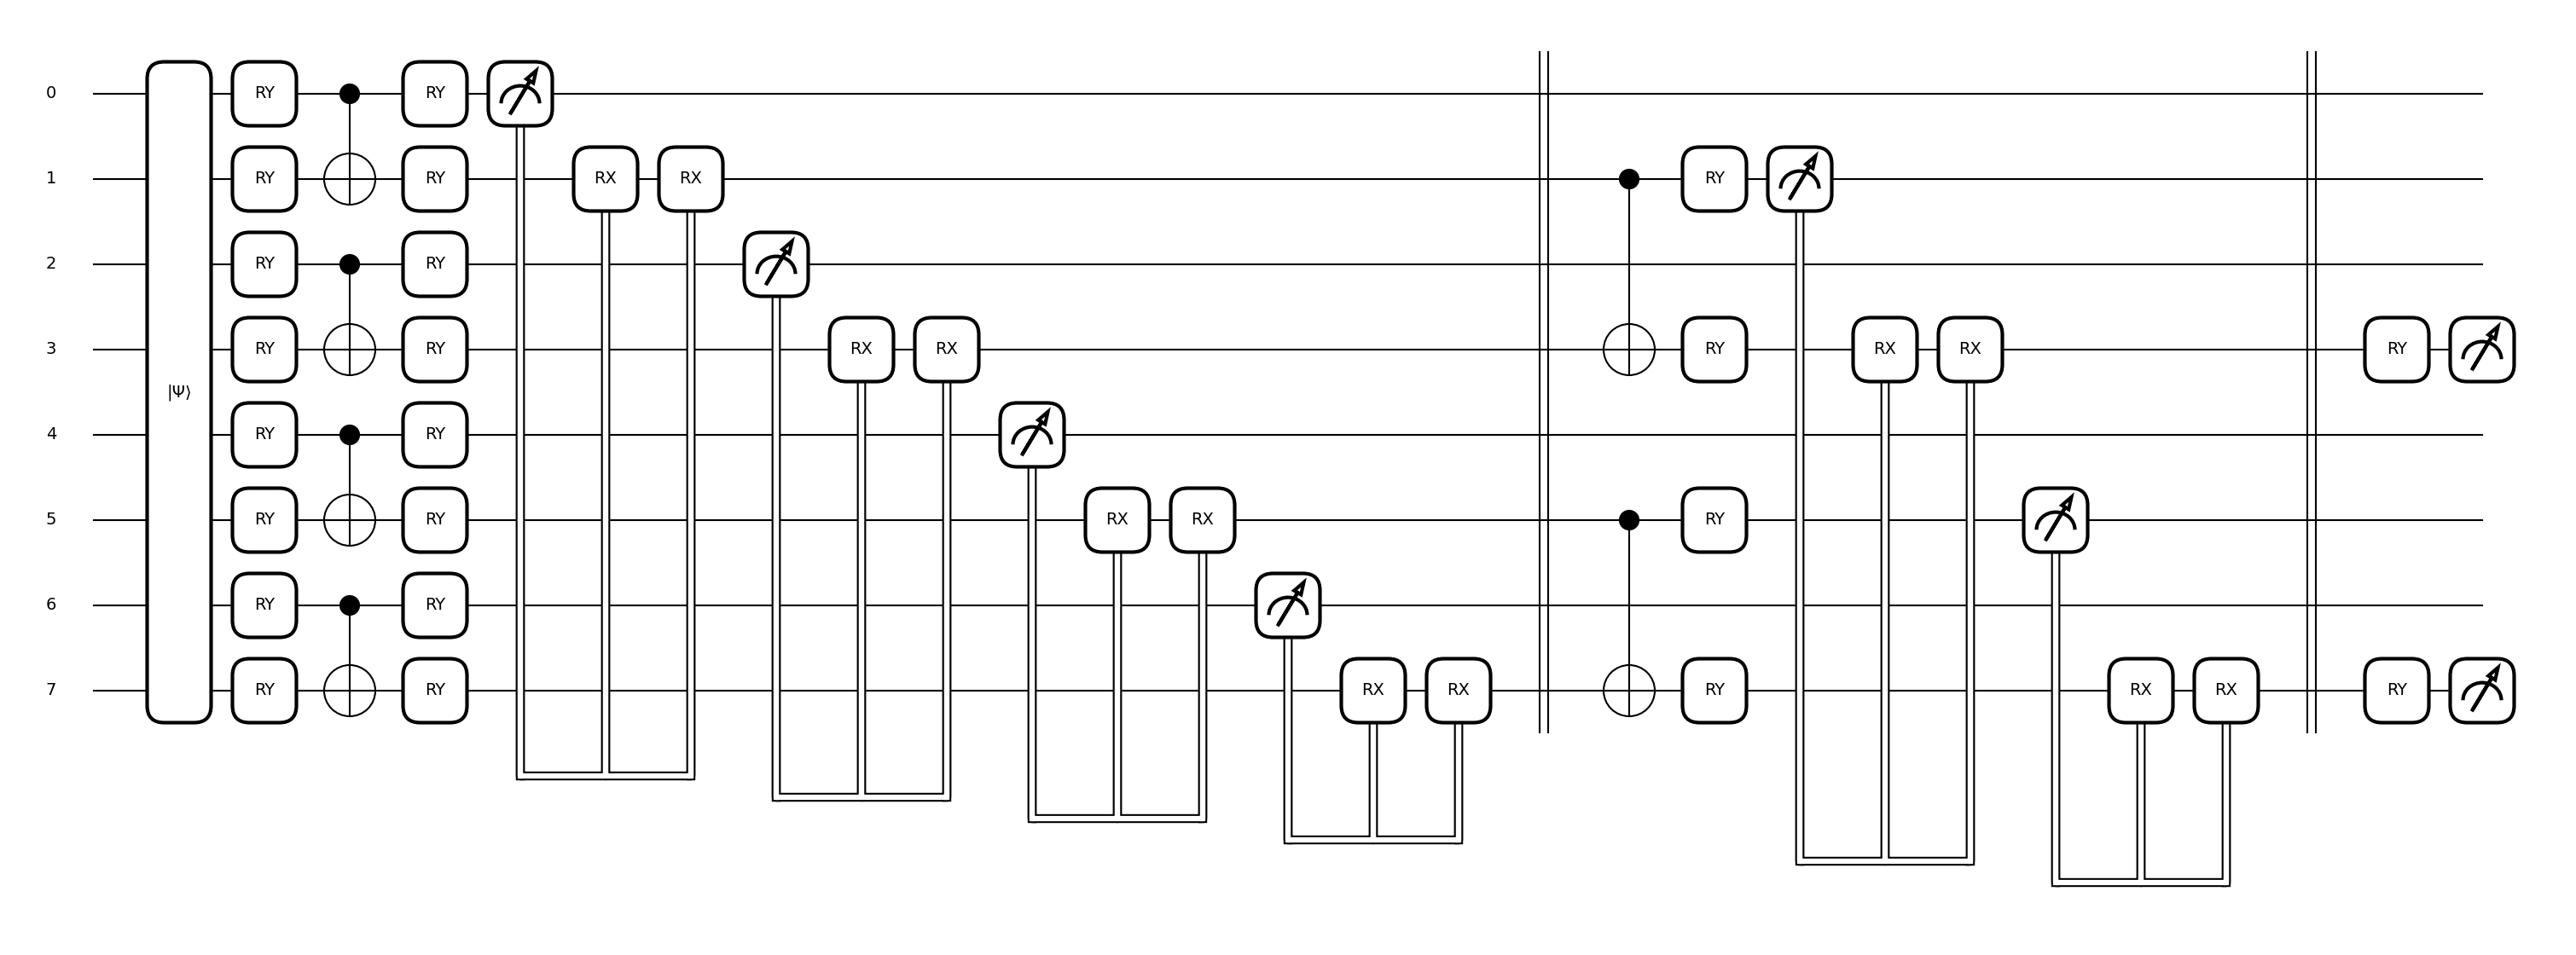

In [6]:
def qcnn_ansatz(num_qubits, params):
    # Convolution block
    def conv(wires, params, index):
        if len(wires) % 2 == 0:
            groups = wires.reshape(-1, 2)
        else:
            groups = wires[:-1].reshape(-1, 2)
            qml.RY(params[index], wires=int(wires[-1]))
            index += 1

        for group in groups:
            qml.CNOT(wires=[int(group[0]), int(group[1])])
            for wire in group:
                qml.RY(params[index], wires=int(wire))
                index += 1

        return index

    # Pooiling block
    def pool(wires, params, index):
        # Process wires in pairs: measure one and conditionally rotate the other.
        for wire_pool, wire in zip(wires[0::2], wires[1::2]):
            m_0 = qml.measure(int(wire_pool))
            qml.cond(m_0 == 0, qml.RX)(params[index],     wires=int(wire))
            qml.cond(m_0 == 1, qml.RX)(params[index + 1], wires=int(wire))
            index += 2
            # Remove the measured wire from active wires.
            wires = np.delete(wires, np.where(wires == wire_pool))

        # If an odd wire remains, apply a RX rotation.
        if len(wires) % 2 != 0:
            qml.RX(params[index], wires=int(wires[-1]))
            index += 1

        return index, wires

    # Initialize active wires and parameter index.
    active_wires = np.arange(num_qubits)
    index = 0

    # Initial layer: apply RY to all wires.
    for wire in active_wires:
        qml.RY(params[index], wires=int(wire))
        index += 1

    # Repeatedly apply convolution and pooling until there are 2 unmeasured wires
    while len(active_wires) > 2:
        # Convolution
        index = conv(active_wires, params, index)
        # Pooling
        index, active_wires = pool(active_wires, params, index)  
        qml.Barrier()

    # Final layer: apply RY to the remaining active wires.
    for wire in active_wires:
        qml.RY(params[index], wires=int(wire))
        index += 1

    return index, active_wires

num_params, output_wires = qcnn_ansatz(num_qubits, [0]*100)

@qml.qnode(qml.device("default.qubit", wires=num_qubits))
def qcnn_circuit(params, state):
    # Input ground state from diagonalization
    qml.StatePrep(state, wires=range(num_qubits), normalize = True)
    # QCNN
    _, output_wires = qcnn_ansatz(num_qubits, params)

    return qml.probs([int(k) for k in output_wires])

qml.draw_mpl(qcnn_circuit)(np.arange(num_params), psis[0,0])

The training is performed by minimizing the **Cross Entropy loss** on the output probabilities:

**Cross Entropy Loss:**  
   $$
   \mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j} y_j^{\frac1T} \log \tilde{p}_j
^\frac1T   $$

Where $y_j$ represents the one-hot encoded labels for the three phases and $T$ is a temperature factor. 

In [7]:
def cross_entropy(pred, Y, T):
    epsilon = 1e-9  # Small value for numerical stability
    pred = jnp.clip(pred, epsilon, 1 - epsilon)  # Prevent log(0)
    
    # Apply sharpening (raise probabilities to the power of 1/T)
    pred_sharpened = pred ** (1 / T)
    pred_sharpened /= jnp.sum(pred_sharpened, axis=1, keepdims=True)  # Re-normalize
    
    loss = -jnp.sum(Y * jnp.log(pred_sharpened), axis=1)
    return jnp.mean(loss)

The analytical points of the ANNNI model correspond to specific regions of the phase diagram where the system simplifies into well-understood limits:

* **Transverse-field Ising model** at $\kappa = 0$ in which we only have the magnetic field and the nearest neighbor interactions;
* **_Quasi classical_ model**  at $h=0$ in which we only have the nearest and next-nearest neighbor interactions.

For these points, we can derive the labels analytically which will then be used for the training of the QCNNs. 

After the training, much alike in [^6] and [^1], we can inspect the model's generalization capabilities, by obtaining the predicted phase for every point across the 2D phase diagram and compare these predictions with the phase boundaries identified through DMRG methods.

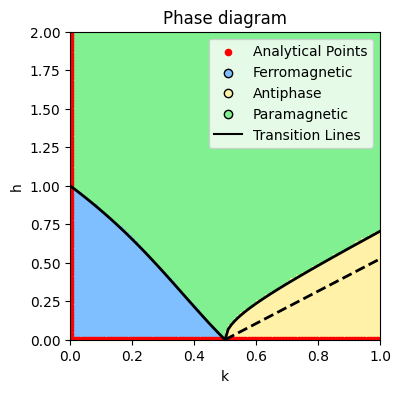

In [8]:
# Plot the phase diagram
plt.figure(figsize=(4, 4))
plt.imshow(img_dmrg, cmap=cmap, aspect="auto", origin="lower", extent=[0, 1, 0, 2], norm=norm)

# Plot the transition lines.
k_vals1 = np.linspace(0.0, 0.5, 50)
k_vals2 = np.linspace(0.5, 1.0, 50)
plt.plot(k_vals1, ising_transition(k_vals1), 'k', lw=2)
plt.plot(k_vals2, kt_transition(k_vals2), 'k', lw=2)
plt.plot(k_vals2, bkt_transition(k_vals2), 'k', ls = '--', lw=2)

# Highlight analytical points (k = 0 and h = 0)
plt.scatter(np.zeros_like(hs100), hs100, color='red', s=20, label="Analytical Points")  # y-axis points
plt.scatter(ks100, np.zeros_like(ks100), color='red', s=20)  # x-axis point
# Create legend entries
for color, phase in zip(colors, phase_labels[:-1]):
    plt.scatter([], [], color=color, label=phase, edgecolors='black')
plt.plot([], [], 'k', label='Transition Lines')

plt.legend(), plt.xlabel("k"), plt.ylabel("h"), plt.title("Phase diagram"), plt.show();

/home/samonaco/envs/annni/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
LOSS: 0.0538: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


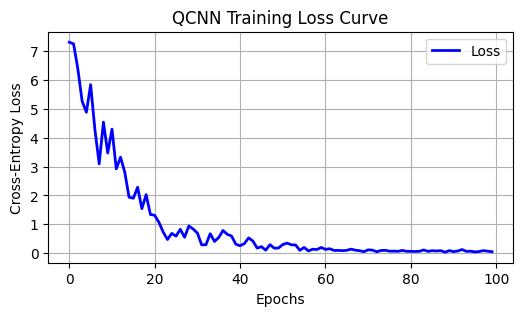

In [9]:
# Mask for the analytical points
analytical_mask = (K == 0) | (H == 0)

# Vectorize the circuit using vmap
vectorized_qcnn_circuit = vmap(jit(qcnn_circuit), in_axes=(None, 0))

def train_qcnn(num_epochs, lr, T, seed):
    # Initialize PRNG key
    key = random.PRNGKey(seed)
    
    # Define the loss function
    def loss_fun(params, X, Y):
        preds = vectorized_qcnn_circuit(params, X)
        return cross_entropy(preds, Y, T)

    # Prepare Training data and labels
    X_train, Y_train = psis[analytical_mask], phases[analytical_mask]
    
    # Randomly initialize the parameters
    key, subkey = random.split(key)
    params = random.normal(subkey, (num_params,))

    # Initialize Adam optimizer
    optimizer = optax.adam(learning_rate=lr)
    optimizer_state = optimizer.init(params)
    progress_bar = tqdm.tqdm(range(num_epochs))
    
    loss_curve = []
    for epoch in progress_bar:
        # Get random indices for a batch
        key, subkey = random.split(key)
        batch_indices = random.choice(subkey, len(X_train), shape=(15,), replace=False)
        
        # Select the corresponding data
        X_batch = jnp.array(X_train[batch_indices])
        # Convert labels to one-hot encoding
        Y_batch = jnp.eye(4)[Y_train[batch_indices]]

        # Compute loss and gradients
        loss, grads = value_and_grad(loss_fun)(params, X_batch, Y_batch)
        
        # Update parameters
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        params = optax.apply_updates(params, updates)
        
        progress_bar.update(1)
        loss_curve.append(loss)
        progress_bar.set_description(f"LOSS: {loss:.4f}")
    
    return params, loss_curve

trained_params, loss_curve = train_qcnn(num_epochs=100, lr=1e-2, T=.1, seed=seed) 

# Plot the loss curve
plt.figure(figsize=(6, 3))
plt.plot(loss_curve, label="Loss", color="blue", linewidth=2)
plt.xlabel("Epochs"), plt.ylabel("Cross-Entropy Loss")
plt.title("QCNN Training Loss Curve")
plt.legend(), plt.grid(), plt.show();

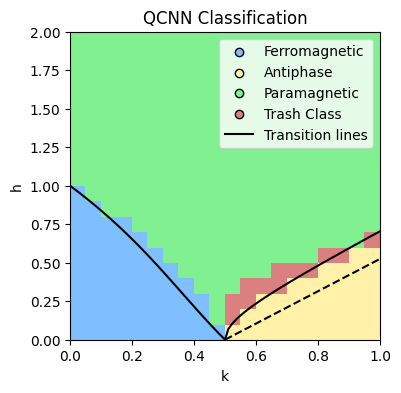

In [10]:
# Take the class from the highest probability value
predicted_classes = np.argmax(
    vectorized_qcnn_circuit(trained_params, psis.reshape(-1, 2**num_qubits)),
    axis=1
)

# Plot the predictions over the phase diagram
plt.figure(figsize=(4, 4))
plt.imshow(
    predicted_classes.reshape(20, 20),
    cmap=cmap,
    norm=norm,
    aspect="auto",
    origin="lower",
    extent=[0, 1, 0, 2]
)

# Plot the transition lines (Ising and KT) for reference.
plt.plot(k_vals1, ising_transition(k_vals1), 'k')
plt.plot(k_vals2, kt_transition(k_vals2), 'k')
plt.plot(k_vals2, bkt_transition(k_vals2), 'k', ls = '--')

for color, phase in zip(colors, phase_labels):
    plt.scatter([], [], color=color, label=phase, edgecolors='black')
plt.plot([], [], 'k', label='Transition lines')

plt.xlabel("k"), plt.ylabel("h")
plt.title("QCNN Classification")
plt.legend()
plt.show()

The trained QCNN successfully generalizes across the entire 2D phase diagram, aligning with the phase boundaries predicted by DMRG. Additionally, across multiple training runs (as this one), the model struggles to distinguish the transition between the anti-phase and paramagnetic phase, often classifying those points as part of a "trash class". This behavior is likely due to the presence of the Floating phase between these two regions. 

[^2] presents an analysis of the QCNN’s performance as the number of qubits (hence the system's size) increases, showing that the overlap between trash class and the expected Floating phase becomes more accurate.  

# Unsupervised Learning of Phases: Quantum Anomaly Detection

Quantum Anomaly Detection was first introduced in [^4] and serves as the quantum counterpart of an Auto-Encoder, with only the encoding (forward) process being trained (due to the inversion property of quantum unitaries).

In this approach, a single state $|\psi(\kappa, h)\rangle$ from the ANNNI model is optimized to find the best circuit parameters such that:

$$
V(\theta)|\psi(\kappa, h)\rangle = |\phi\rangle^{N-K} \otimes |0\rangle^{\otimes K}
$$

This means we seek a unitary transformation that disentangles the input state into a compressed state $|\phi\rangle$ for a subset of qubits (referred to as _non-trash qubits_) while mapping the remaining qubits (called _trash qubits_) to the zero state.



(<Figure size 2200x900 with 1 Axes>, <Axes: >)

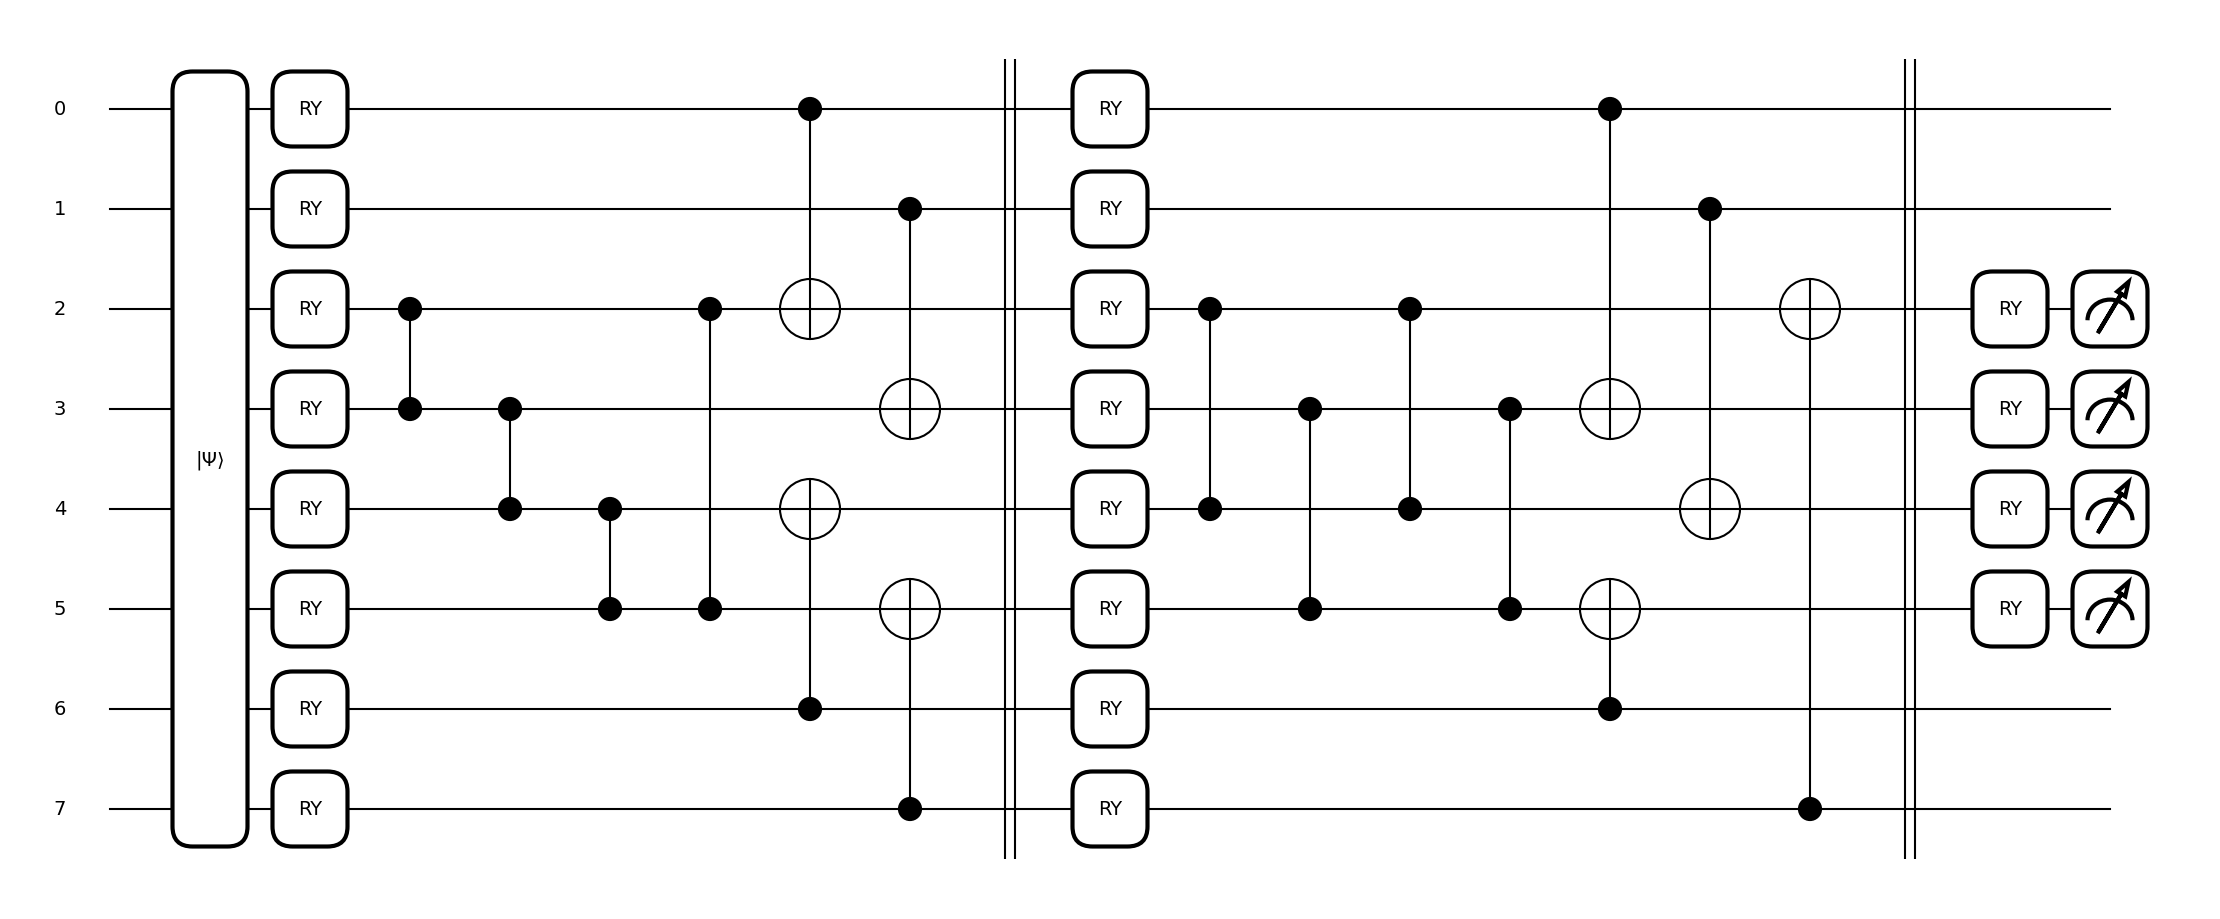

In [11]:
# Quantum Anomaly Circuit Ansatz
def anomaly_ansatz(n_qubit, params):
    # Block of gates connecting trash and non-trash wires
    def block(nontrash, trash, shift):
        # Connect trash wires
        for i, wire in enumerate(trash):
            target = trash[(i + 1 + shift) % len(trash)]
            qml.CZ(wires=[int(wire), int(target)])
        # Connect each nontrash wire to a trash wire
        for i, wire in enumerate(nontrash):
            trash_idx = (i + shift) % len(trash)
            qml.CNOT(wires=[int(wire), int(trash[trash_idx])])

    depth = 2  # Number of repeated block layers
    n_trashwire = n_qubit // 2

    # Define trash wires as a contiguous block in the middle.
    trash = np.arange(n_trashwire // 2, n_trashwire // 2 + n_trashwire)
    nontrash = np.setdiff1d(np.arange(n_qubit), trash)

    index = 0

    # Initial layer: apply RY rotations on all wires.
    for wire in np.arange(n_qubit):
        qml.RY(params[index], wires=int(wire))
        index += 1

    # Repeatedly apply blocks of entangling gates and additional rotations.
    for shift in range(depth):
        block(nontrash, trash, shift)
        qml.Barrier()
        # In the final layer, only apply rotations on trash wires.
        wires_to_rot = np.arange(n_qubit) if shift < depth - 1 else trash
        for wire in wires_to_rot:
            qml.RY(params[index], wires=int(wire))
            index += 1

    return index, list(trash)

num_anomaly_params, trash_wires = qcnn_ansatz(num_qubits, [0]*100)

@qml.qnode(qml.device("default.qubit", wires=num_qubits))
def anomaly_circuit(params, state):
    # Input ground state from diagonalization
    qml.StatePrep(state, wires=range(num_qubits), normalize = True)
    # Quantum Anomaly Circuit
    _, trash_wires = anomaly_ansatz(num_qubits, params)

    return [qml.expval(qml.PauliZ(int(k))) for k in trash_wires]

qml.draw_mpl(anomaly_circuit)(np.arange(num_anomaly_params), psis[0,0])

The training process for this architecture follows these steps:

1. **Selection of Training Event:**  
   A single quantum state is selected as the training event.

2. **Compression Objective:**  
   The training is performed to achieve the compression of the selected quantum state. This is done by minimizing the following loss function, known as the *compression score*:
   $$\mathcal{C} = \frac{1}{2}\sum_{j\in q_T} (1-\left<Z_j\right>)$$
   where $q_T$ refers to the set of trash qubits, which make up $N/2$ of the total.
   
   By doing so, all the information of the input quantum state is compressed in the remaining non-measured qubits.
   
In this case, the selected quantum state corresponds to the trivial case with $\kappa = 0$ and $h = 0$.

LOSS: 0.0001: 100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


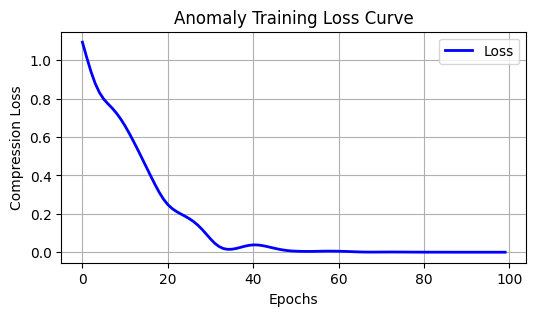

In [12]:
# Vectorize the circuit using vmap
jitted_anomaly_circuit = jit(anomaly_circuit)
vectorized_anomaly_circuit = vmap(jitted_anomaly_circuit, in_axes=(None, 0))

def train_anomaly(num_epochs, lr, seed):
    # Initialize PRNG key
    key = random.PRNGKey(seed)
    
    # Define the loss function
    def loss_fun(params, X):
        # Output expectation values of the qubits
        score = 1 - jnp.array(jitted_anomaly_circuit(params, X))
        loss_value = jnp.mean(score)

        return loss_value

    # Training set consists only of the k = 0 and h = 0 point
    X_train = jnp.array(psis[0, 0])
    
    # Randomly initialize parameters
    key, subkey = random.split(key)
    params = random.normal(subkey, (num_anomaly_params,))

    optimizer = optax.adam(learning_rate=lr)
    optimizer_state = optimizer.init(params)
    progress_bar = tqdm.tqdm(range(num_epochs))
    
    loss_curve = []
    for epoch in progress_bar:
        # Get random indices for a batch
        key, subkey = random.split(key)

        # Compute loss and gradients
        loss, grads = value_and_grad(loss_fun)(params, X_train)
        
        # Update parameters
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        params = optax.apply_updates(params, updates)
        
        progress_bar.update(1)
        loss_curve.append(loss)
        progress_bar.set_description(f"LOSS: {loss:.4f}")
    
    return params, loss_curve

trained_anomaly_params, anomaly_loss_curve = train_anomaly(num_epochs=100, lr=1e-1, seed=seed) 

# Plot the loss curve
plt.figure(figsize=(6, 3))
plt.plot(anomaly_loss_curve, label="Loss", color="blue", linewidth=2)
plt.xlabel("Epochs"), plt.ylabel("Compression Loss")
plt.title("Anomaly Training Loss Curve")
plt.legend(), plt.grid(), plt.show();

After training the circuit to optimally compress the $(0,0)$ state, we can assess the compression score for all other input states using the learned parameters.

The model is expected to achieve near-optimal compression for states similar to the training state (namely those belonging to the same phase) resulting in a low compression score. Conversely, states from different phases should exhibit poorer compression, leading to a higher compression score.

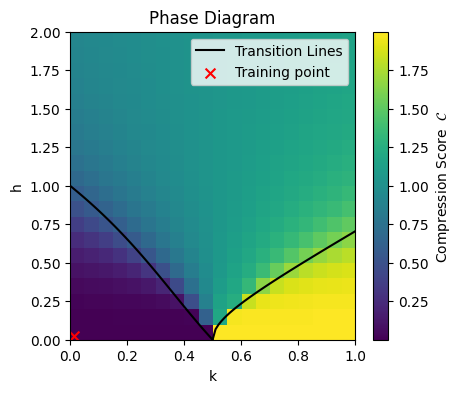

In [13]:
compressions = vectorized_anomaly_circuit(trained_anomaly_params, psis.reshape(-1, 2**num_qubits))
compressions = jnp.mean(1 - jnp.array(compressions), axis = 0)

plt.figure(figsize=(4.6, 4))
im = plt.imshow(compressions.reshape(20, 20), aspect="auto", origin="lower", extent=[0, 1, 0, 2])

# Plot transition lines (assuming ising_transition and kt_transition are defined)
plt.plot(np.linspace(0.0, 0.5, 50), ising_transition(np.linspace(0.0, 0.5, 50)), 'k')
plt.plot(np.linspace(0.5, 1.0, 50), kt_transition(np.linspace(0.5, 1.0, 50)), 'k')

plt.plot([], [], 'k', label='Transition Lines')
plt.scatter([0 +.3/len(ks)], [0 + .5/len(hs)], color='r', marker = 'x', label="Training point", s=50)

plt.legend(), plt.xlabel("k"), plt.ylabel("h"), plt.title("Phase Diagram")
cbar = plt.colorbar(im)
cbar.set_label(r"Compression Score  $\mathcal{C}$")
plt.show()

As expected, the compression score is nearly zero within the ferromagnetic phase, while higher scores are observed in the other regions. Surprisingly, however, the other regions display distinct compression scores that remain consistent within their respective areas.

Using this model, we can clearly identify the three phases and their locations. Furthermore, as observed in [^2], by increasing the system size (starting from ~20 spins), a fourth phase emerges in the anticipated floating phase region. These regions are expected to become more sharply defined at larger system sizes, with more pronounced transitions between phases.

# Conclusion

Overall, quantum many-body systems are an interesting use case for QML models. In this tutorial, we presented two potential models for such application.

First, with the QCNN we highlighted how the high generalization capabilities of such models can be exploited, while the QAD showed a promising application to system which phases are yet unknown.

An advantage may be achieved by applying these models to spin systems that are non-classically simulable, particularly in cases where the interactions are less local and cannot be accurately described by Tensor Network representations.

# References

[^1] Saverio Monaco, Oriel Kiss, Antonio Mandarino, Sofia Vallecorsa, Michele Grossi 
    \"Quantum phase detection generalization from marginal quantum neural network models.\" [arxiv:2208.08748](https://arxiv.org/abs/2208.08748), 2023.

[^2] Maria Cea, Michele Grossi, Saverio Monaco, Enrique Rico, Luca Tagliacozzo, Sofia Vallecorsa
    \"Exploring the Phase Diagram of the quantum one-dimensional ANNNI model.\" [arxiv:2402.11022](https://arxiv.org/abs/2402.11022), 2023.

[^3] Alberto Peruzzo, Jarrod McClean, Peter Shadbolt, Man-Hong Yung, Xiao-Qi Zhou, Peter J. Love, Alán Aspuru-Guzik, Jeremy L. O'Brien
    \"A variational eigenvalue solver on a quantum processor.\" [arxiv:1304.3061](https://arxiv.org/abs/1304.3061), 2013.

[^4] Korbinian Kottmann, Friederike Metz, Joana Fraxanet, Niccolo Baldelli
    \"Variational Quantum Anomaly Detection: Unsupervised mapping of phase diagrams on a physical quantum computer.\" [arxiv:2106.07912](https://arxiv.org/abs/2106.07912), 2022.

[^5] Iris Cong, Soonwon Choi, Mikhail D. Lukin
    \"Quantum Convolutional Neural Networks.\" [arxiv:1810.03787](https://arxiv.org/abs/1810.03787), 2019.

[^6] Matthias C. Caro, Hsin-Yuan Huang, Marco Cerezo, Kunal Sharma, Andrew Sornborger, Lukasz Cincio, Patrick J. Coles
    \"Generalization in quantum machine learning from few training data.\" [arxiv:2111.05292](https://arxiv.org/abs/2111.05292), 2022.